In [ ]:
pip install gymnasium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.1 MB/s eta 0:00:00


In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import time
import pygame
import pickle
import seaborn as sns
import pandas as pd

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
# variable to store the number of feature in a state, 2 in our case.
state_size = env.observation_space.shape[0]

In [4]:
# variable to store the number of possible actions at each state, 3 in our case.
action_size = env.action_space.n # variable to sto

## First steps

In [5]:
class RandomAgent :

    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.state_size = state_size

    def observe(self, state, action, next_state, reward):
        # For a random agent, we don't do anything with observations.
        pass

    def select_action(self, state):
        # Randomly choose an action from the action space.
        return env.action_space.sample()

    def update(self):
        # No update needed for a random agent.
        pass


In [6]:
random_agent = RandomAgent(state_size, action_size)

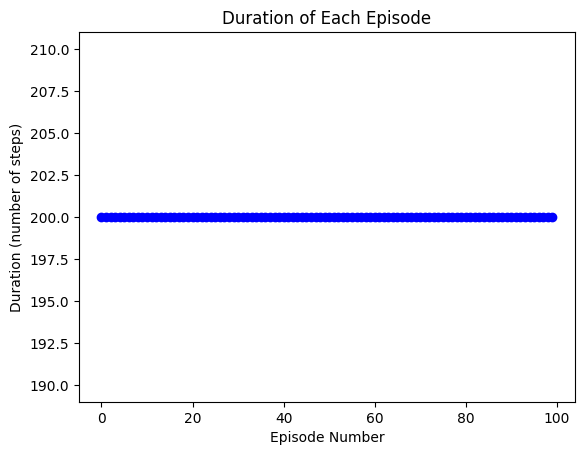

In [ ]:
# Prepare to store episode durations
episode_durations = []

for e in range(100):
    done = False
    random_seed = random.randint(1, 100000)
    state, _ = env.reset(seed = random_seed)
    episode_reward = 0

    while not done:
        action = random_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward

        state = next_state
        done = terminated or truncated

    duration = -episode_reward
    episode_durations.append(duration)

plt.scatter(range(100), episode_durations, color='blue')
plt.title("Duration of Each Episode")
plt.xlabel("Episode Number")
plt.ylabel("Duration (number of steps)")
plt.show()

### Comments

We can see given the scatter plot that the random agent performs very poorly, playing the maximum numbers of steps at each game and not solving the problem at all.

In [7]:
# Class to represent a RND network. The RND network (target or predictor) takes as input a state representation and outputs a single number.
# We made the choice to have a single hidden layer, however the number of hidden layers so as the number of neurons per layer can be twisted
# for further optimizations.
class RNDNetwork(nn.Module):
  def __init__(self, lr, input_dims, fc1_dims):
    super(RNDNetwork, self).__init__()
    self.input_dims = input_dims
    self.fc1_dims = fc1_dims
    self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, 1)
    self.optimizer = optim.Adam(self.parameters(), lr= lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
  def forward(self, state):
        x = F.relu(self.fc1(state))
        val = self.fc2(x)

        return val

In [8]:
# Class to represent a Deep Q network. The DQN takes as input a state representation and outputs a Q-value for each possible action within the state.

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr= lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

In [9]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=10000, eps_end=0.05, eps_dec=5e-4, RNDOrHeuristique=False):

        # Agent's parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = list(range(n_actions))
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.RNDOrHeuristique = RNDOrHeuristique


        # Networks
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=64, fc2_dims=64)
        self.predictor = RNDNetwork(self.lr, input_dims=input_dims, fc1_dims=64)
        self.target = RNDNetwork(self.lr, input_dims=input_dims, fc1_dims=64)

        # Agent's memory
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

        # Running means and stds for normalization
        self.state_mean = np.zeros(input_dims)
        self.state_std = np.ones(input_dims) + 1e-8  # Avoid division by zero by adding a small epsilon
        self.state_count = 1  # Avoid division by zero

        self.reward_mean = 0
        self.reward_std = 1 + 1e-8  # Avoid division by zero by adding a small epsilon
        self.reward_count = 1

    # function to update the running means and stds of states and rewards.
    def update_running_mean_std(self, new_value, old_mean, old_std, count):
        new_mean = old_mean + (new_value - old_mean) / count
        new_M2 = old_std ** 2 * (count - 1) + (new_value - old_mean) * (new_value - new_mean)
        new_std = np.sqrt(new_M2 / count) if count > 1 else np.sqrt(new_M2) + 1e-8  # Avoid division by zero
        return new_mean, new_std

    def compute_rnd_reward(self, next_state):
        self.state_mean, self.state_std = self.update_running_mean_std(next_state, self.state_mean, self.state_std, self.state_count)
        self.state_count += 1

        normalized_state = (next_state - self.state_mean) / self.state_std # state normalization before feeding to the networks
        normalized_state_array = np.array([normalized_state])  # Convert to numpy array first to improve performance
        target_output = self.target(T.tensor(normalized_state_array, dtype=T.float32)) # target(new_state)
        predictor_output = self.predictor(T.tensor(normalized_state_array, dtype=T.float32)) # predictor(new_state)

        squared_diff = T.pow(target_output - predictor_output, 2).mean()

        # Update reward normalization parameters
        self.reward_mean, self.reward_std = self.update_running_mean_std(squared_diff.item(), self.reward_mean, self.reward_std, self.reward_count)
        self.reward_count += 1

        normalized_diff = (squared_diff.item() - self.reward_mean) / self.reward_std # Normalization of the squared difference between predictor and target using a running estimate of its mean and std
        clamped_rnd_reward = np.clip(normalized_diff, -5, 5)

        return clamped_rnd_reward


    def observe(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr +=1

    def choose_action(self,observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(np.array([observation]), dtype=T.float32).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        batch_index = np.arange(self.batch_size, dtype = np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        if self.RNDOrHeuristique:
          #Predictor network training
          self.predictor.optimizer.zero_grad()
          target_pred = self.target(new_state_batch) # target network should not be trained, only used as a target for the predictor network
          predictor_pred = self.predictor(new_state_batch)
          predictor_loss = T.nn.functional.mse_loss(predictor_pred, target_pred)
          predictor_loss.backward()
          self.predictor.optimizer.step()

        self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)
        return loss.item()




In [10]:
# heuristic reward function based on the mechanical energy of the engine
def mechanical_energy_reward(state, next_state):
    # Extract position and velocity from current and next state
    x, v = state[0], state[1]
    x_next, v_next = next_state[0], next_state[1]

    # Calculate current and next mechanical energy
    E_current = 0.5 * v**2 + x
    E_next = 0.5 * v_next**2 + x_next

    # Change in mechanical energy
    delta_E = E_next - E_current

    # Reward is positive if there is an increase in energy, otherwise negative
    if delta_E > 0:
        reward = delta_E  # Reward the increase in mechanical energy
    else:
        reward = delta_E  # Penalize the decrease in mechanical energy

    return reward

Episode  0 score: 200.00 average score: 200.00 epsilon: 0.83
Episode  100 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  200 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  300 score: 200.00 average score: 197.88 epsilon: 0.05
Episode  400 score: 157.00 average score: 188.71 epsilon: 0.05
Episode  500 score: 200.00 average score: 194.70 epsilon: 0.05
Episode  600 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  700 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  800 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  900 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1000 score: 200.00 average score: 198.56 epsilon: 0.05
Episode  1100 score: 115.00 average score: 181.39 epsilon: 0.05
Episode  1200 score: 200.00 average score: 173.30 epsilon: 0.05
Episode  1300 score: 145.00 average score: 184.77 epsilon: 0.05
Episode  1400 score: 155.00 average score: 156.28 epsilon: 0.05
Episode  1500 score: 200.00 average score: 172.80 ep

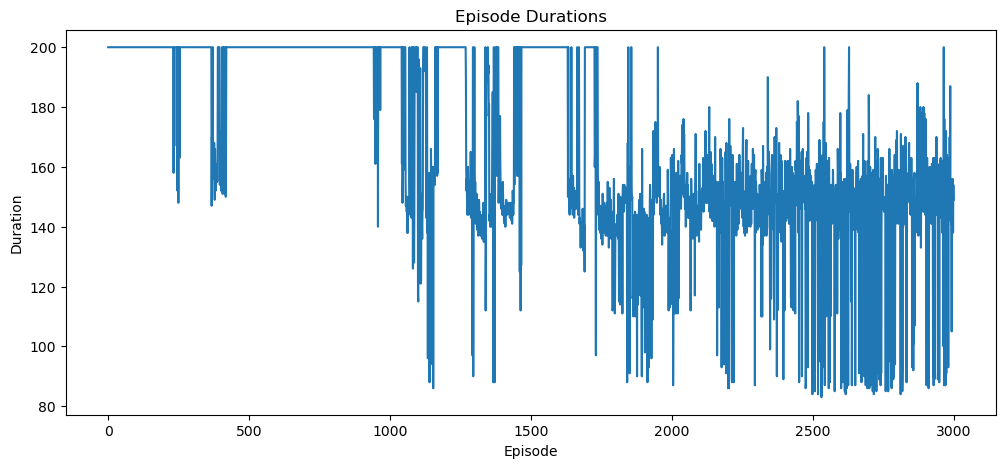

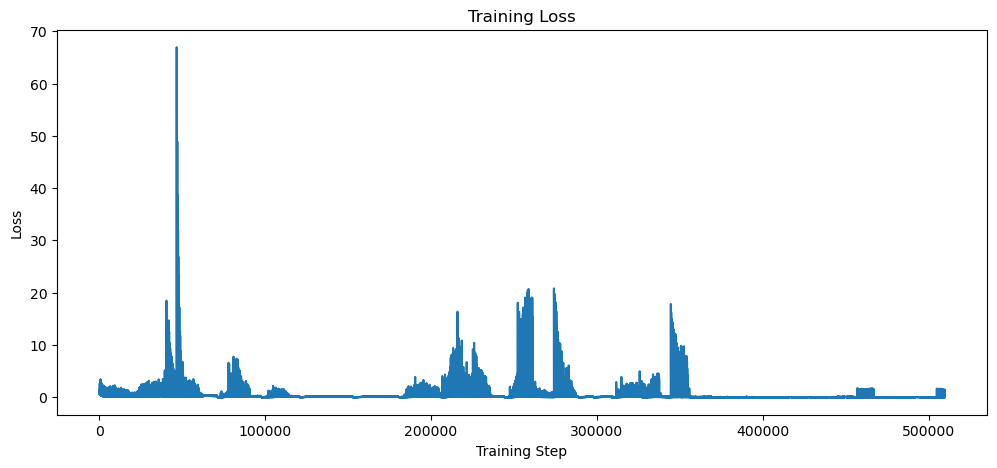

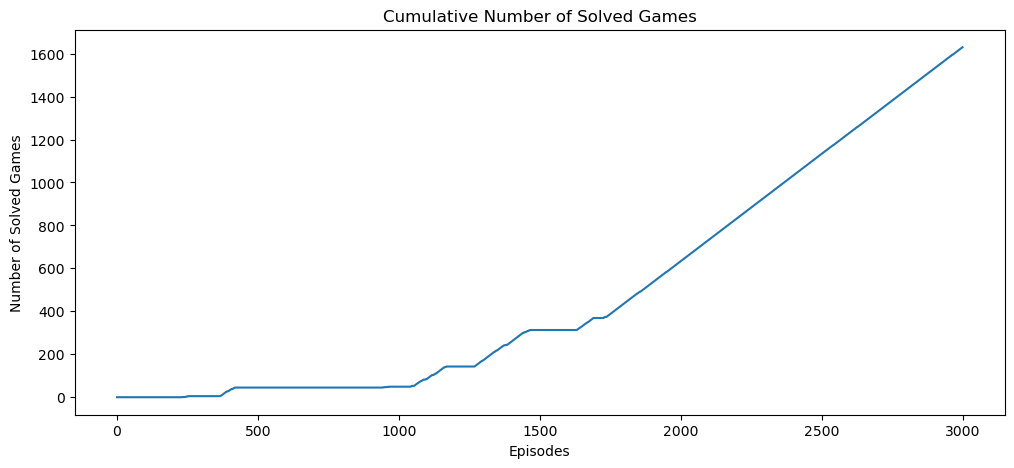

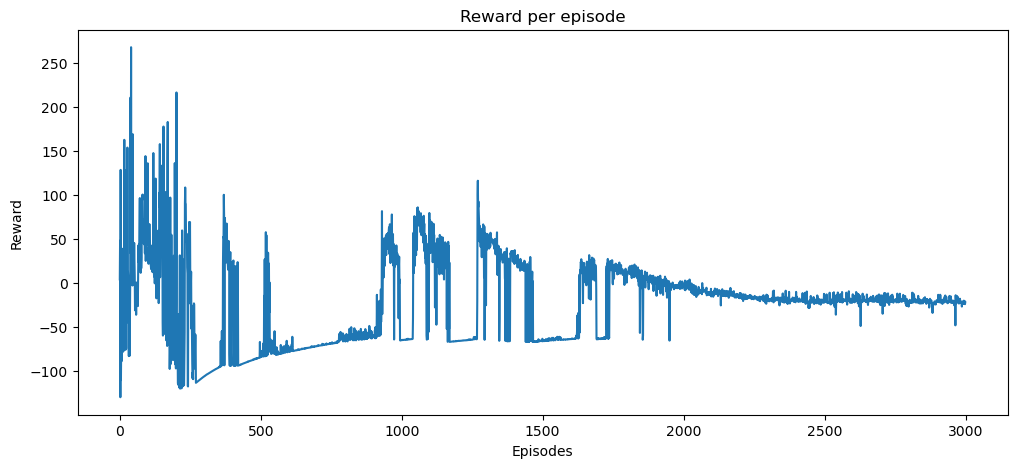

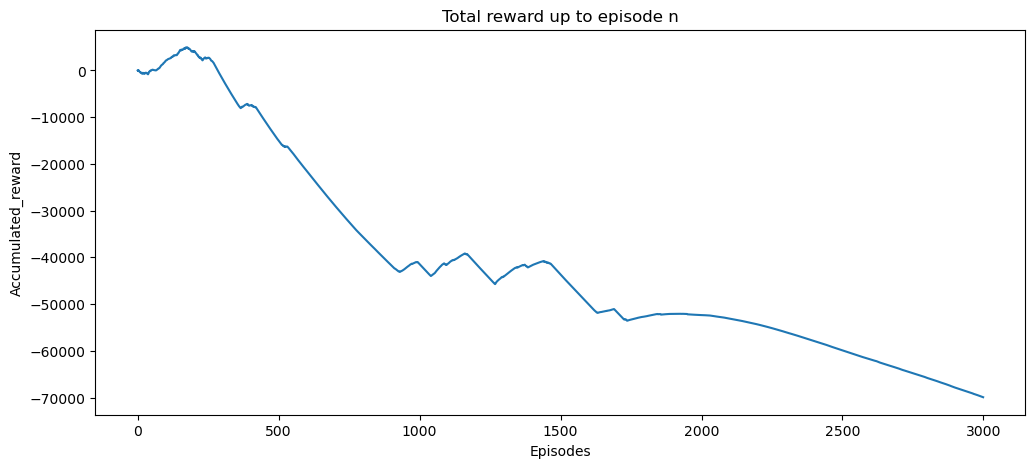

In [17]:
# Initialize the agent
agent_1 = Agent(gamma=0.99, epsilon=0.9, lr=0.001, input_dims=[state_size], batch_size=64, n_actions=action_size, eps_end=0.05, RNDOrHeuristique=True)
scores_1, eps_history_1, loss_history_1, solved_count_history_1, accumulated_reward_per_ep_1, total_reward_up_to_n_1, rewards_from_env_1 = [], [], [], [], [], [], []
n_games_1 = 3000
solved_games_1 = 0  # Counter for the number of games solved
total_reward_up_to_now_1 = 0

for i in range(n_games_1):
    steps, total_reward, total_env_reward, done = 0, 0, 0, False
    observation, _ = env.reset()
    while not done:
        action = agent_1.choose_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        total_env_reward += reward
        reward = agent_1.compute_rnd_reward(observation_) # change to mechanical_energy reward to train the agent with heuristic reward function
        steps += 1
        done = terminated or truncated
        agent_1.observe(observation, action, reward, observation_, done)
        loss = agent_1.learn() # When training the agent with heuristic reward, comment out the update of the predictor network for optimization.
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_1 += reward
        loss_history_1.append(loss)

    scores_1.append(steps)
    eps_history_1.append(agent_1.epsilon)
    rewards_from_env_1.append(total_env_reward)
    accumulated_reward_per_ep_1.append(total_reward)
    total_reward_up_to_n_1.append(total_reward_up_to_now_1)
    if steps < 200:
        solved_games_1 += 1
    solved_count_history_1.append(solved_games_1)

    avg_score = np.mean(scores_1[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % agent_1.epsilon)

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_1)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_history_1)
plt.title('Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_1)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_1)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_1)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()



Episode  0 score: 200.00 average score: 200.00 epsilon: 0.83
Episode  100 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  200 score: 200.00 average score: 185.08 epsilon: 0.05
Episode  300 score: 200.00 average score: 188.03 epsilon: 0.05
Episode  400 score: 200.00 average score: 191.03 epsilon: 0.05
Episode  500 score: 200.00 average score: 152.93 epsilon: 0.05
Episode  600 score: 200.00 average score: 191.96 epsilon: 0.05
Episode  700 score: 200.00 average score: 182.21 epsilon: 0.05
Episode  800 score: 200.00 average score: 199.16 epsilon: 0.05
Episode  900 score: 200.00 average score: 176.77 epsilon: 0.05
Episode  1000 score: 200.00 average score: 196.99 epsilon: 0.05
Episode  1100 score: 200.00 average score: 199.90 epsilon: 0.05
Episode  1200 score: 200.00 average score: 179.87 epsilon: 0.05
Episode  1300 score: 200.00 average score: 165.50 epsilon: 0.05
Episode  1400 score: 200.00 average score: 154.05 epsilon: 0.05
Episode  1500 score: 200.00 average score: 198.55 ep

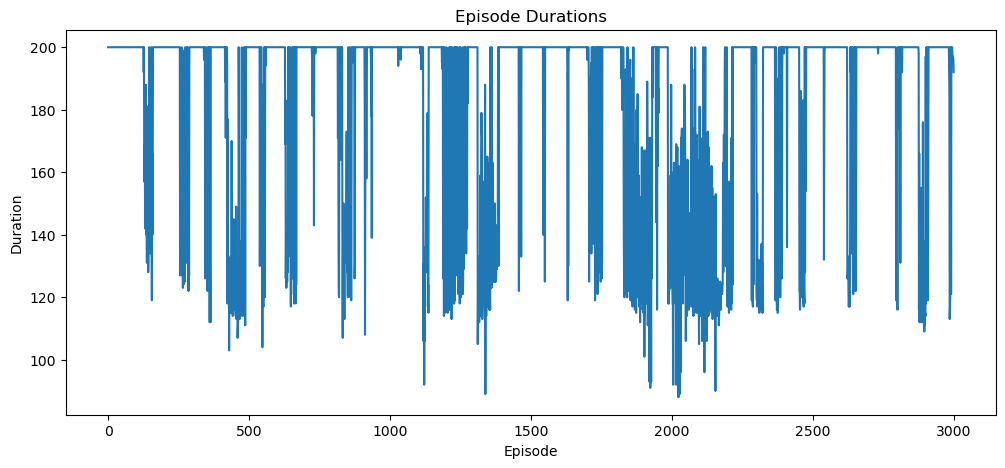

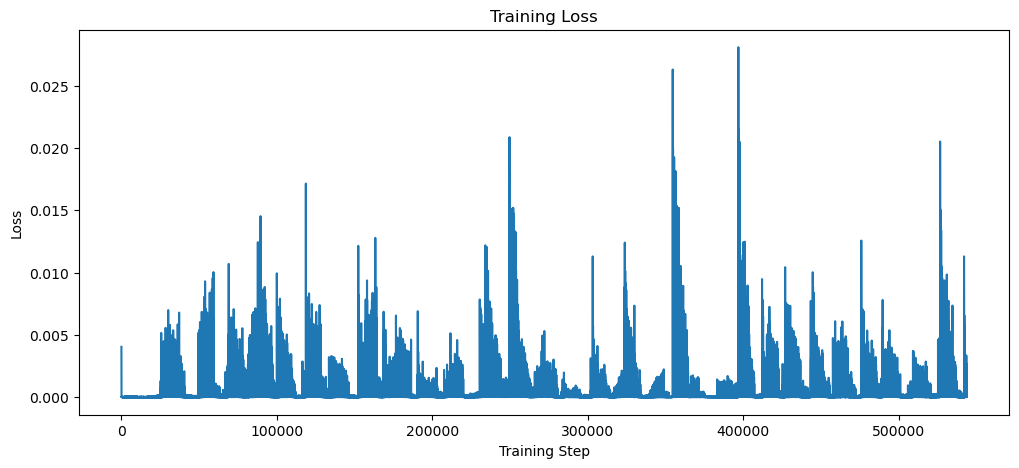

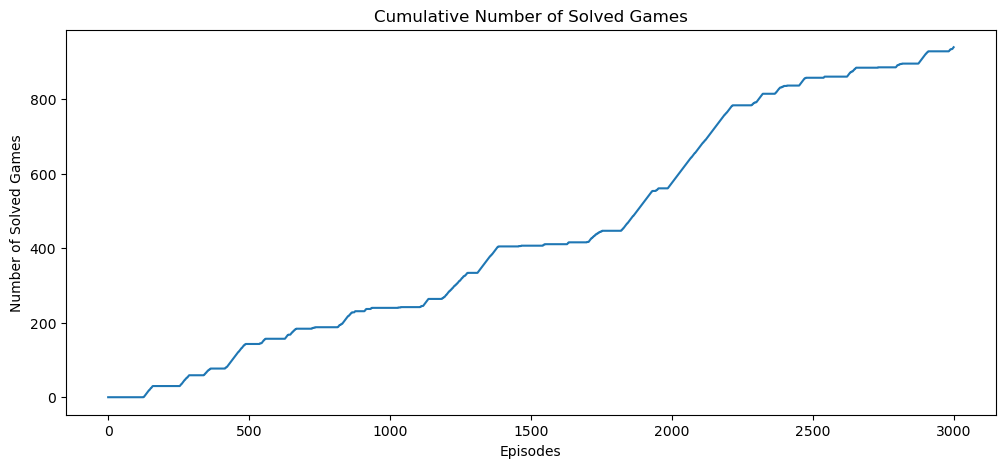

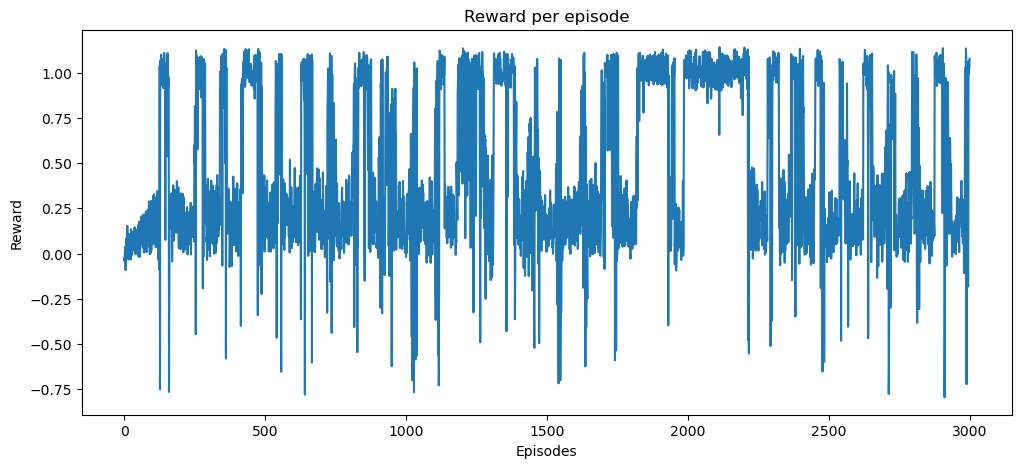

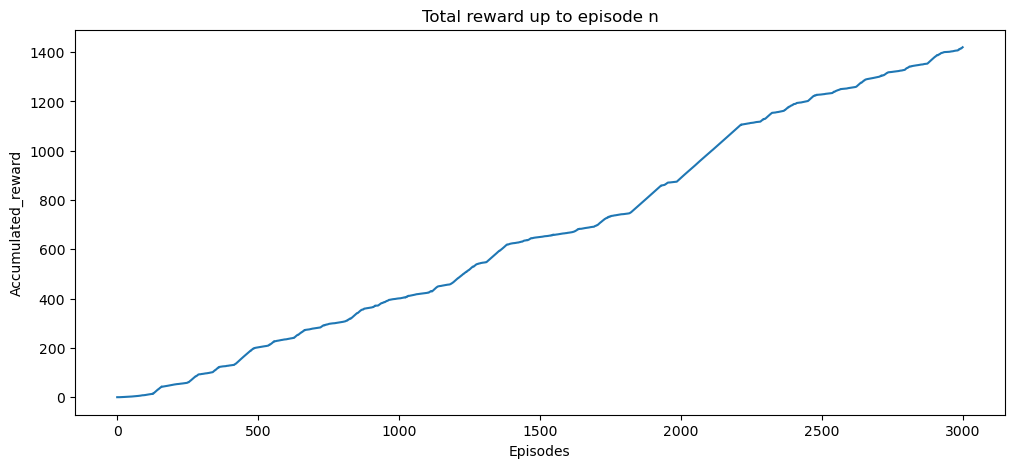

In [18]:
# Initialize the agent
agent_2 = Agent(gamma=0.99, epsilon=0.9, lr=0.001, input_dims=[state_size], batch_size=64, n_actions=action_size, eps_end=0.05, RNDOrHeuristique=False)
scores_2, eps_history_2, loss_history_2, solved_count_history_2, accumulated_reward_per_ep_2, total_reward_up_to_n_2, rewards_from_env_2 = [], [], [], [], [], [], []
n_games_2 = 3000
solved_games_2 = 0  # Counter for the number of games solved
total_reward_up_to_now_2 = 0

for i in range(n_games_2):
    steps, total_reward, total_env_reward, done = 0, 0, 0, False
    observation, _ = env.reset()
    while not done:
        action = agent_2.choose_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        total_env_reward += reward
        reward = mechanical_energy_reward(observation, observation_)
        steps += 1
        done = terminated or truncated
        agent_2.observe(observation, action, reward, observation_, done)
        loss = agent_2.learn() # When training the agent with heuristic reward, comment out the update of the predictor network for optimization.
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_2 += reward
        loss_history_2.append(loss)

    scores_2.append(steps)
    eps_history_2.append(agent_2.epsilon)
    rewards_from_env_2.append(total_env_reward)
    accumulated_reward_per_ep_2.append(total_reward)
    total_reward_up_to_n_2.append(total_reward_up_to_now_2)
    if steps < 200:
        solved_games_2 += 1
    solved_count_history_2.append(solved_games_2)

    avg_score = np.mean(scores_2[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % agent_2.epsilon)

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_2)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_history_2)
plt.title('Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_2)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_2)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_2)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()



In [11]:
def round_nearest(x, a):
    return round(x / a) * a

class dynaAgent():
    def __init__(self, discr_step, γ, e, k):
        self.discr_step = discr_step
        self.γ = γ
        self.e = e
        self.k = k

        P = dict()
        R = dict()
        Q = dict()

        listOfState = []
        minX = round_nearest(env.observation_space.low[0], discr_step[0])
        maxX = round_nearest(env.observation_space.high[0], discr_step[0])
        minVel = round_nearest(env.observation_space.low[1], discr_step[1])
        maxVel = round_nearest(env.observation_space.high[1], discr_step[1])

        for x in np.arange(minX, maxX+discr_step[0], discr_step[0]):
            for vel in np.arange(minVel, maxVel+discr_step[1], discr_step[1]):
                listOfState.append([round(x,5), round(vel,5)])

        listOfAction = []
        for action in np.arange(env.action_space.start, env.action_space.start + env.action_space.n):
            listOfAction += [action]

        #prob = 1.0/len(listOfState)
        for stateIni in listOfState:
            for action in listOfAction:
                R[(stateIni[0], stateIni[1], action)] = 0
                Q[(stateIni[0], stateIni[1], action)] = 0
                #for stateFin in listOfState:
                    #P[(stateIni[0], stateIni[1], action, stateFin[0], stateFin[1])] = prob

        self.P = P
        self.R = R
        self.Q = Q
        self.P_opti = dict()

        self.listOfState = listOfState
        self.listOfAction = listOfAction

    def observe(self, state, action, next_state, reward):
        #t_start = time.time()
        #called upon observing a new transition of the environment.
        stateIni = [0,0]
        stateIni[0] = round(round_nearest(state[0], self.discr_step[0]),5)
        stateIni[1] = round(round_nearest(state[1], self.discr_step[1]),5)

        stateFin = [0,0]
        stateFin[0] = round(round_nearest(next_state[0], self.discr_step[0]),5)
        stateFin[1] = round(round_nearest(next_state[1], self.discr_step[1]),5)

        currentDict = self.P.get((stateIni[0], stateIni[1], action), {str(stateFin): [stateFin, 0], "total": 0})
        newState = currentDict.get(str(stateFin), [stateFin, 0])
        currentDict[str(stateFin)] = [newState[0], newState[1] + 1]
        currentDict["total"] += 1
        self.P[(stateIni[0], stateIni[1], action)] = currentDict

        self.P_opti[(stateIni[0], stateIni[1], action)] = 1

        self.R[(stateIni[0], stateIni[1], action)] = reward
        sumOfProb = 0


        for n, v in self.P[(stateIni[0], stateIni[1], action)].items():
            if n == "total":
                continue

            stateIter = v[0]

            maxElem = self.Q[(stateIter[0], stateIter[1], self.listOfAction[0])]
            for actionIter in self.listOfAction[1:]:
                elem = self.Q[(stateIter[0], stateIter[1], actionIter)]
                if elem > maxElem:
                    maxElem = elem
            sumOfProb += self.P[(stateIni[0], stateIni[1], action)][str(stateIter)][1]/self.P[(stateIni[0], stateIni[1], action)]["total"] * maxElem

        changeReward = (reward + self.γ * sumOfProb) - self.Q[(stateIni[0], stateIni[1], action)]
        self.Q[(stateIni[0], stateIni[1], action)] = reward + self.γ * sumOfProb
        #t_end = time.time()
        returnMean = self.update()
        returnMean = (changeReward + returnMean)/(self.k)
        self.e[0] = max([self.e[0] * 0.9998, self.e[1]])

        #print("observedTime = " + str(t_end-t_start))
        return abs(returnMean)

    def select_action(self, state):
        #t_start = time.time()
        #pick an action from the given state.
        p = random.random()

        if (p < self.e[0]):
            #t_end = time.time()
            #print("selectTime = " + str(t_end-t_start))
            return env.action_space.sample()
        else:
            stateRounded = [0,0]
            stateRounded[0] = round(round_nearest(state[0], self.discr_step[0]), 5)
            stateRounded[1] = round(round_nearest(state[1], self.discr_step[1]), 5)
            bestAction = self.listOfAction[0]
            for action in self.listOfAction[1:]:
                if (self.Q[(stateRounded[0], stateRounded[1], action)] >= self.Q[(stateRounded[0], stateRounded[1], bestAction)]):
                    bestAction = action
            #t_end = time.time()
            #print("selectTime = " + str(t_end-t_start))

            return bestAction

    def update(self):
        #t_start = time.time()
        elemsSeen = list(self.P_opti.items())
        changeReward = 0

        for i in range(self.k):
            testState = [0,0]
            (testState[0], testState[1], testAction), _ = random.choice(elemsSeen)

            sumOfProb = 0

            for n, v in self.P[(testState[0], testState[1], testAction)].items():
                if n == "total":
                    continue

                stateIter = v[0]

                maxElem = self.Q[(stateIter[0], stateIter[1], self.listOfAction[0])]
                for actionIter in self.listOfAction[1:]:
                    elem = self.Q[(stateIter[0], stateIter[1], actionIter)]
                    if elem > maxElem:
                        maxElem = elem
                sumOfProb += self.P[(testState[0], testState[1], testAction)][str(stateIter)][1]/self.P[(testState[0], testState[1], testAction)]["total"] * maxElem

            changeReward += (self.R[(testState[0], testState[1], testAction)] + self.γ * sumOfProb) - self.Q[(testState[0], testState[1], testAction)]
            self.Q[(testState[0], testState[1], testAction)] = self.R[(testState[0], testState[1], testAction)] + self.γ * sumOfProb
        #t_end = time.time()
        #print("updateTime = " + str(t_end-t_start))
        return changeReward

In [20]:
with open('Models.pkl', 'wb') as outp:
    pickle.dump(agent_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(agent_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(scores_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(scores_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(eps_history_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(eps_history_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(loss_history_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(loss_history_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(solved_count_history_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(solved_count_history_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(accumulated_reward_per_ep_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(accumulated_reward_per_ep_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_n_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_n_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(rewards_from_env_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(rewards_from_env_2, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_now_1, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_now_2, outp, pickle.HIGHEST_PROTOCOL)



Episode  0 score: 200.00 average score: 200.00 epsilon: 0.86
Episode  100 score: 156.00 average score: 192.42 epsilon: 0.05
Episode  200 score: 163.00 average score: 166.12 epsilon: 0.05
Episode  300 score: 160.00 average score: 162.49 epsilon: 0.05
Episode  400 score: 144.00 average score: 156.38 epsilon: 0.05
Episode  500 score: 140.00 average score: 149.93 epsilon: 0.05
Episode  600 score: 147.00 average score: 150.48 epsilon: 0.05
Episode  700 score: 148.00 average score: 149.28 epsilon: 0.05
Episode  800 score: 153.00 average score: 143.17 epsilon: 0.05
Episode  900 score: 119.00 average score: 145.49 epsilon: 0.05
Episode  1000 score: 120.00 average score: 144.77 epsilon: 0.05
Episode  1100 score: 139.00 average score: 143.51 epsilon: 0.05
Episode  1200 score: 115.00 average score: 143.04 epsilon: 0.05
Episode  1300 score: 151.00 average score: 138.85 epsilon: 0.05
Episode  1400 score: 157.00 average score: 143.09 epsilon: 0.05
Episode  1500 score: 144.00 average score: 137.23 ep

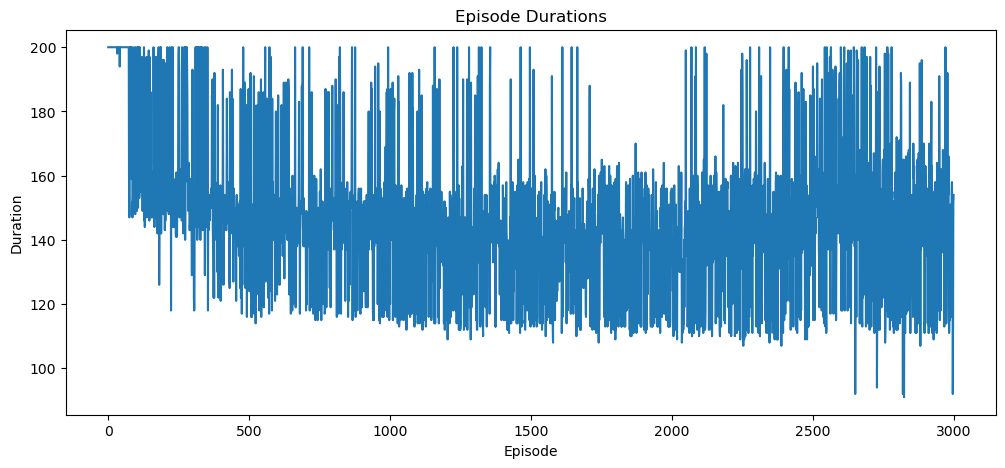

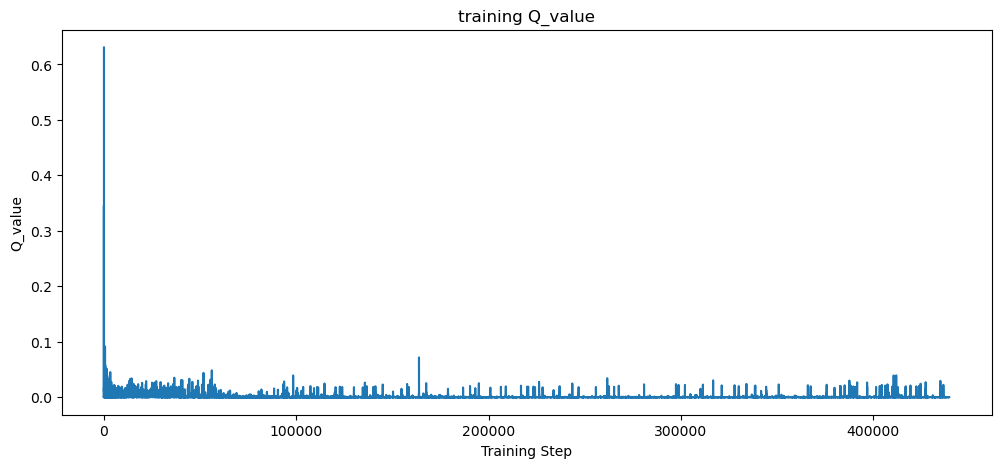

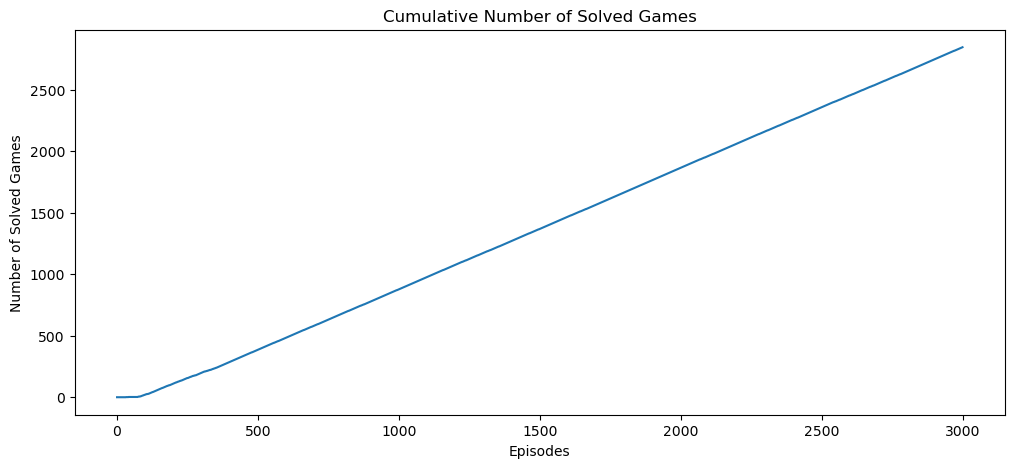

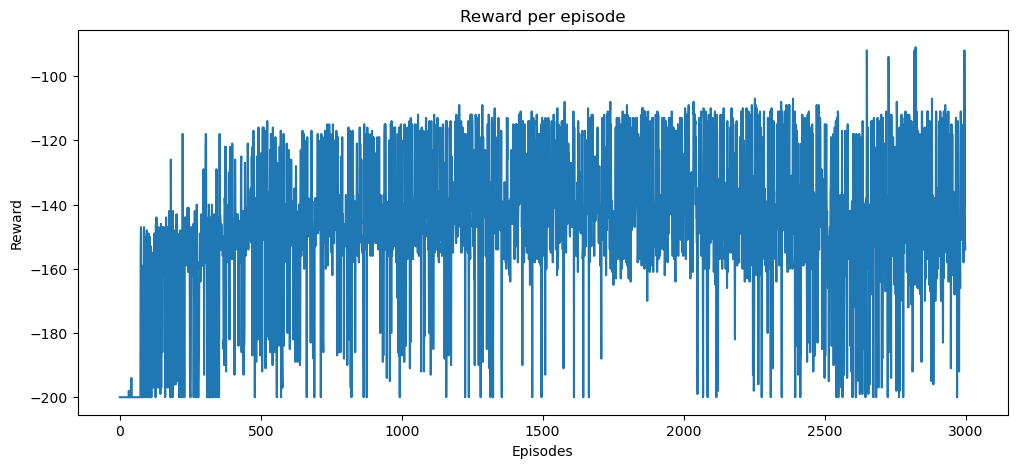

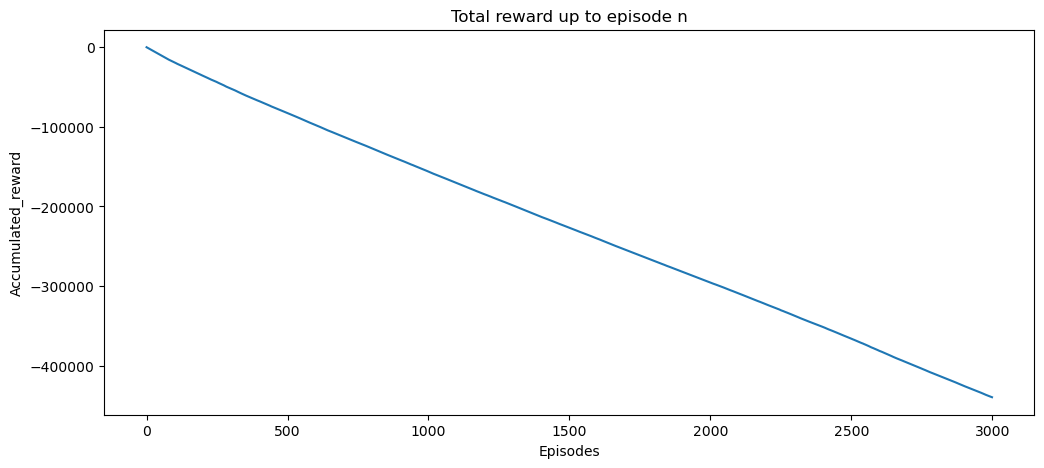

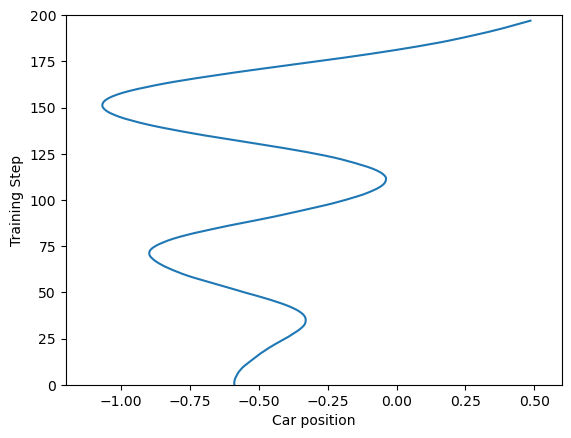

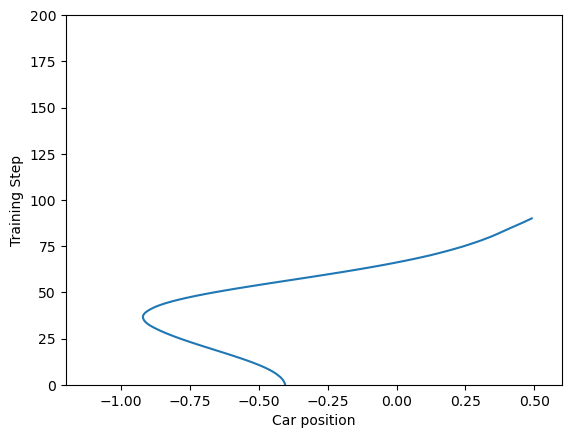

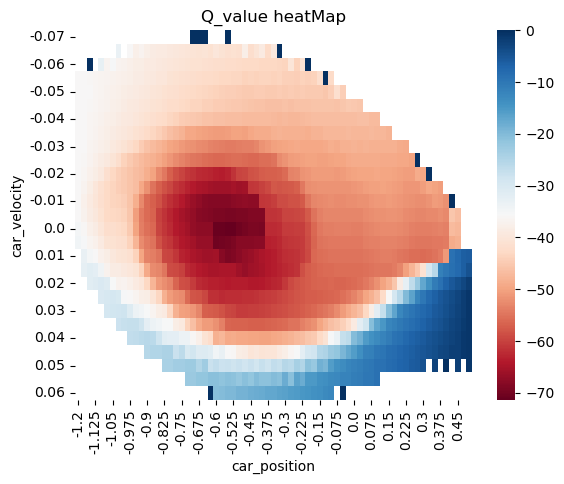

NameError: name 'loss_history_3' is not defined

In [21]:
dynaAgSave = dynaAgent([0.025,0.0050], 0.99, [0.9, 0.05], 2000)

scores_3, eps_history_3, solved_count_history_3, accumulated_reward_per_ep_3, total_reward_up_to_n_3, Qval = [], [], [], [], [], []
n_games_3 = 3000
solved_games_3 = 0  # Counter for the number of games solved
total_reward_up_to_now_3 = 0
imgs = [[], []]
smallest = 200

for i in range(n_games_3):
    steps, total_reward, done = 0, 0, False
    observation, _ = env.reset()
    imgTemp = []
    while not done:
        imgTemp.append(observation[0])
        action = dynaAgSave.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        Qval.append(dynaAgSave.observe(observation, action, observation_, reward))
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_3 += reward

    scores_3.append(steps)
    accumulated_reward_per_ep_3.append(total_reward)
    total_reward_up_to_n_3.append(total_reward_up_to_now_3)
    if steps < 200:
        solved_games_3 += 1
        if smallest == 200:
            imgs[0] = imgTemp
            smallest = steps
        if steps < smallest:
            imgs[1] = imgTemp
            smallest = steps

    solved_count_history_3.append(solved_games_3)

    avg_score = np.mean(scores_3[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % dynaAgSave.e[0])

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_3)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(Qval)
plt.title('training Q_value')
plt.xlabel('Training Step')
plt.ylabel('Q_value')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_3)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_3)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_3)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()

for img in imgs:
    ax = plt.gca()
    ax.plot(img)
    ax.set_xlim([env.observation_space.low[0], env.observation_space.high[0]])
    ax.set_ylim([0, 200])
    newx = ax.lines[0].get_ydata()
    newy = ax.lines[0].get_xdata()

    # set new x- and y- data for the line
    ax.lines[0].set_xdata(newx)
    ax.lines[0].set_ydata(newy)
    plt.ylabel('Training Step')
    plt.xlabel('Car position')
    plt.show()

xs = []
ys = []
Qs = []
seen = []

for k in dynaAgSave.P_opti.keys():
    if (k[0], k[1]) in seen:
        continue

    seen += [(k[0], k[1])]
    xs += [k[0]]
    ys += [k[1]]

    maxElem = dynaAgSave.Q[(k[0], k[1], dynaAgSave.listOfAction[0])]
    for actionIter in dynaAgSave.listOfAction[1:]:
        elem = dynaAgSave.Q[(k[0], k[1], actionIter)]
        if elem > maxElem:
            maxElem = elem
    Qs += [maxElem]

df = pd.DataFrame.from_dict(np.array([xs,ys,Qs]).T)
df.columns = ['car_position','car_velocity','max_Q_value']
df['Z_value'] = pd.to_numeric(df['max_Q_value'])
pivotted= df.pivot(index='car_velocity', columns='car_position', values='max_Q_value')
ax = sns.heatmap(pivotted,cmap='RdBu')
plt.title('Q_value heatMap')
plt.show()

with open('DynaModel.pkl', 'wb') as outp:
    pickle.dump(dynaAgSave, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(scores_3, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(eps_history_3, outp, pickle.HIGHEST_PROTOCOL)


In [38]:
n_games = 10

timeStart = time.time()
dynaAgTest1 = dynaAgent([0.00025,0.0005], 0.99, [0.9, 0.05], 2000)
for i in range(n_games):
    done = False
    observation, _ = env.reset()
    while not done:
        action = dynaAgTest1.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        dynaAgTest1.observe(observation, action, observation_, reward)
        observation = observation_
timeEnd = time.time()

timeStart2 = time.time()
dynaAgTest2 = dynaAgent([0.025,0.0050], 0.99, [0.9, 0.05], 2000)
for i in range(n_games):
    done = False
    observation, _ = env.reset()
    while not done:
        action = dynaAgTest2.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        dynaAgTest2.observe(observation, action, observation_, reward)
        observation = observation_
timeEnd2 = time.time()

print("time needed for an episode with small discretization values : " + str((timeEnd-timeStart)/n_games))
print("time needed for an episode with normal discretization values : " + str((timeEnd2-timeStart2)/n_games))

time needed for an episode with small discretization values : 1.8763911724090576
time needed for an episode with normal discretization values : 0.9407498121261597


In [58]:
with open('DynaModelFollow.pkl', 'wb') as outp:
    pickle.dump(Qval, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(solved_count_history_3, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(accumulated_reward_per_ep_3, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_n_3, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(total_reward_up_to_now_3, outp, pickle.HIGHEST_PROTOCOL)

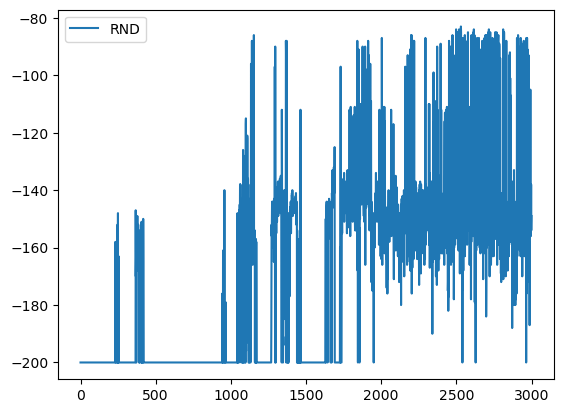

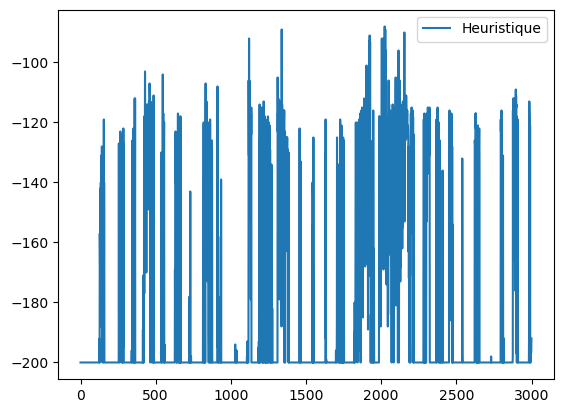

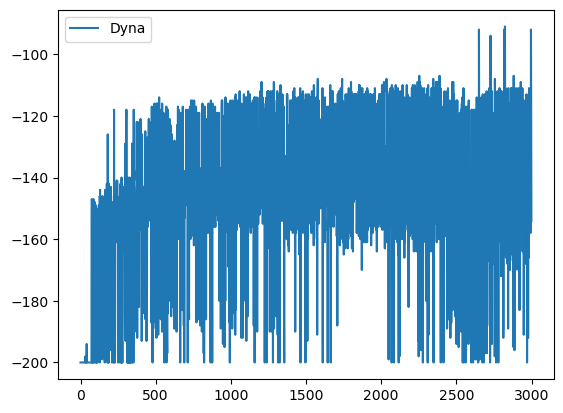

In [29]:
plt.plot(rewards_from_env_1, label = "RND") 
plt.legend() 
plt.show()
plt.plot(rewards_from_env_2, label = "Heuristique") 
plt.legend() 
plt.show()
plt.plot(accumulated_reward_per_ep_3, label = "Dyna")
plt.legend() 
plt.show()

Episode  0 score: 164.00 average score: 164.00 epsilon: 0.00
Episode  100 score: 115.00 average score: 132.12 epsilon: 0.00
Episode  200 score: 94.00 average score: 133.05 epsilon: 0.00
Episode  300 score: 163.00 average score: 136.15 epsilon: 0.00
Episode  400 score: 134.00 average score: 132.60 epsilon: 0.00
Episode  500 score: 135.00 average score: 136.80 epsilon: 0.00
Episode  600 score: 150.00 average score: 135.12 epsilon: 0.00
Episode  700 score: 110.00 average score: 135.62 epsilon: 0.00
Episode  800 score: 162.00 average score: 133.83 epsilon: 0.00
Episode  900 score: 162.00 average score: 137.08 epsilon: 0.00


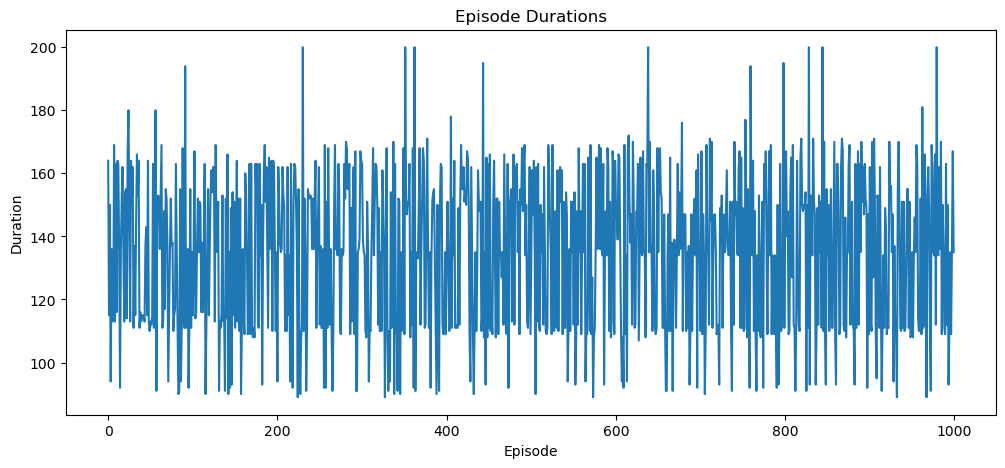

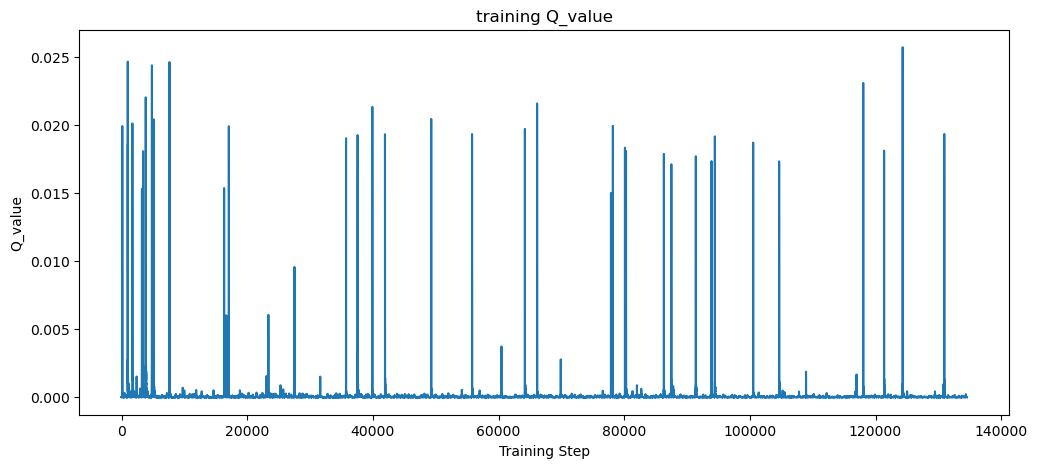

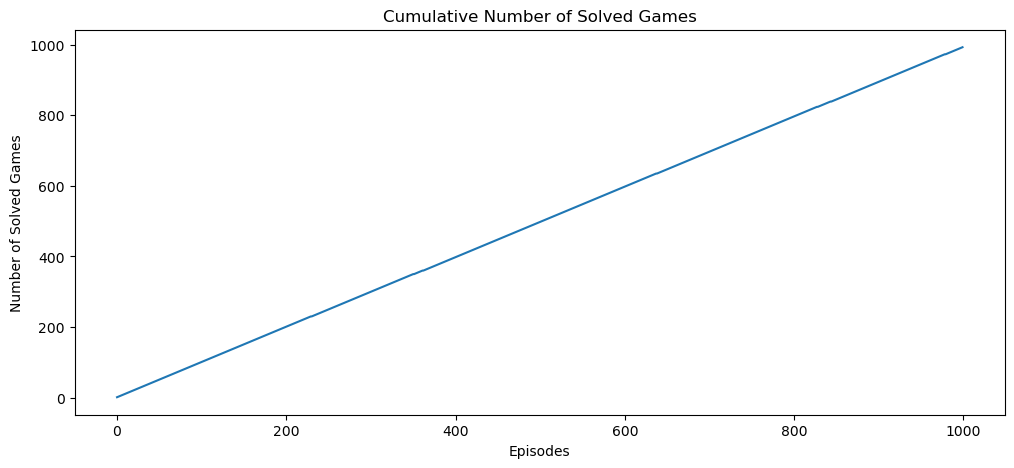

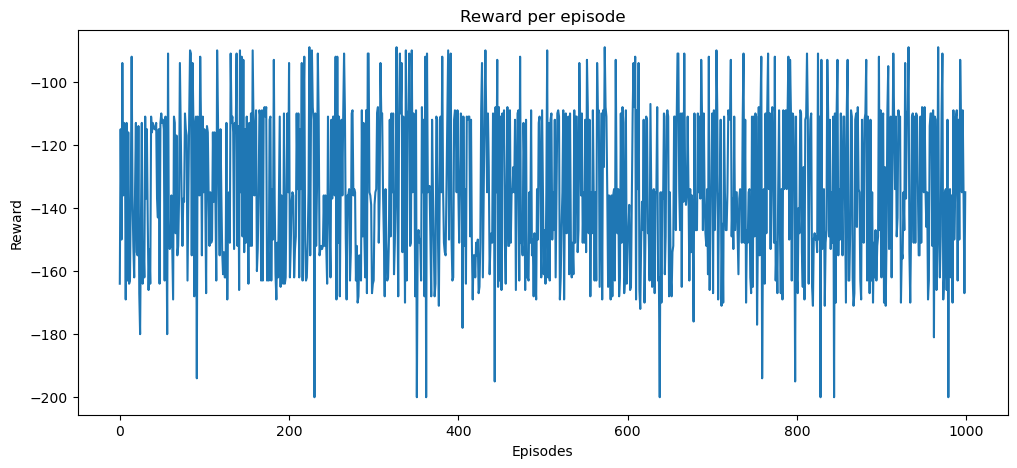

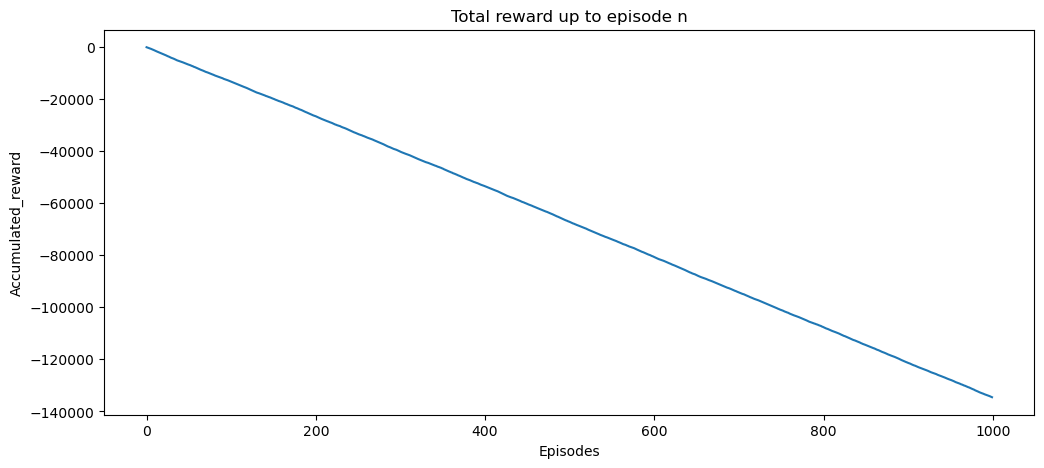

Episode  0 score: 200.00 average score: 200.00 epsilon: 0.00
Episode  100 score: 115.00 average score: 180.76 epsilon: 0.00
Episode  200 score: 200.00 average score: 174.05 epsilon: 0.00
Episode  300 score: 200.00 average score: 170.85 epsilon: 0.00
Episode  400 score: 130.00 average score: 189.87 epsilon: 0.00
Episode  500 score: 200.00 average score: 186.95 epsilon: 0.00
Episode  600 score: 122.00 average score: 178.07 epsilon: 0.00
Episode  700 score: 130.00 average score: 157.08 epsilon: 0.00
Episode  800 score: 200.00 average score: 170.46 epsilon: 0.00
Episode  900 score: 197.00 average score: 199.90 epsilon: 0.00


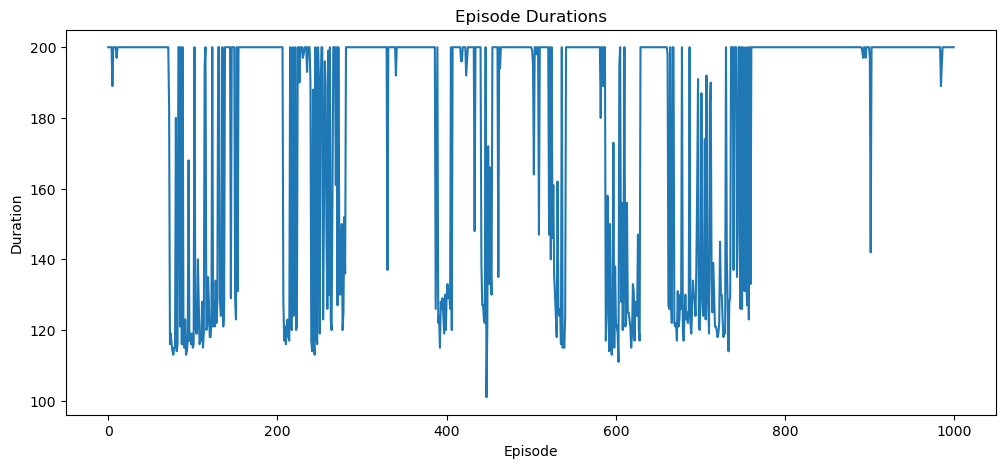

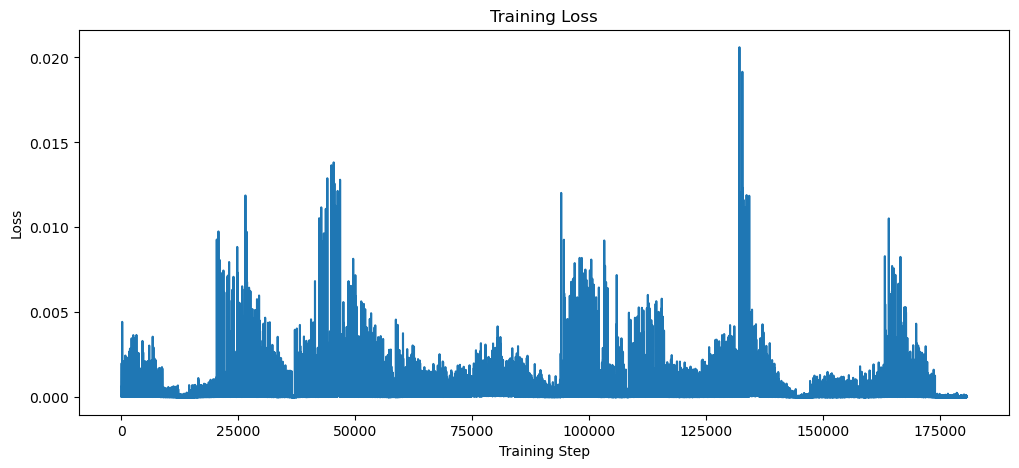

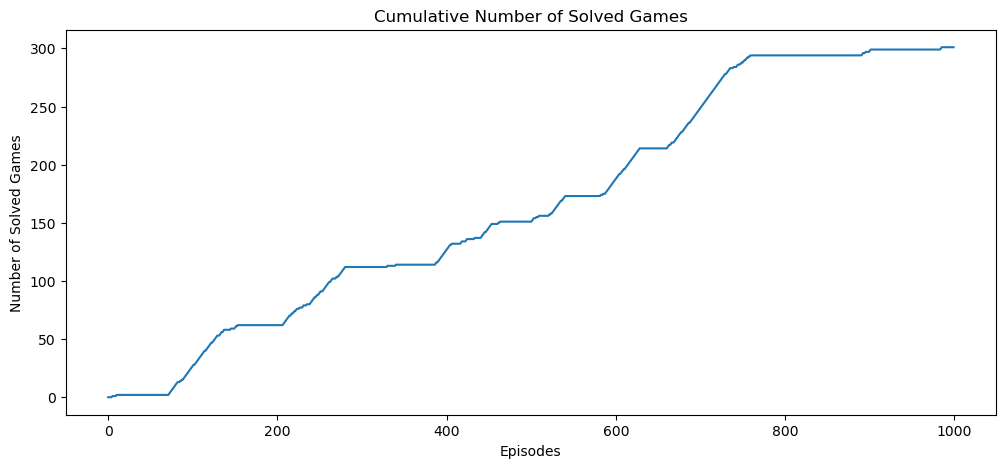

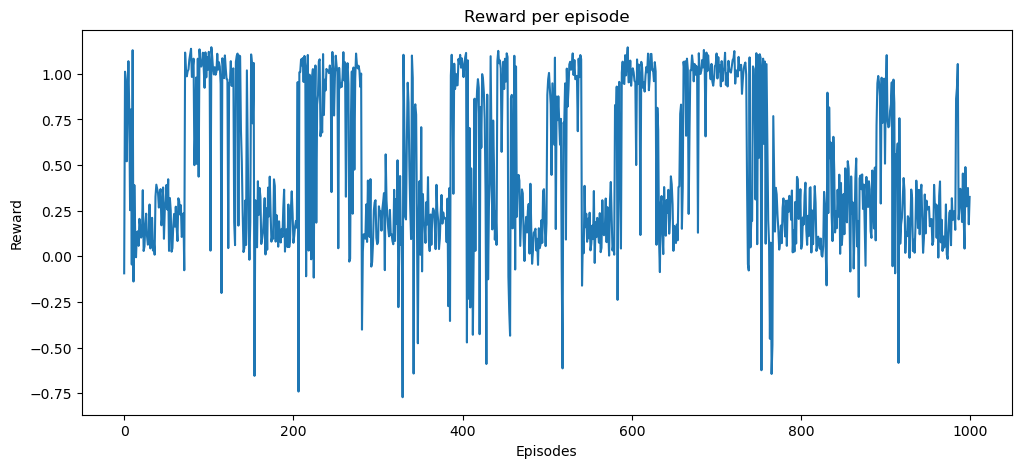

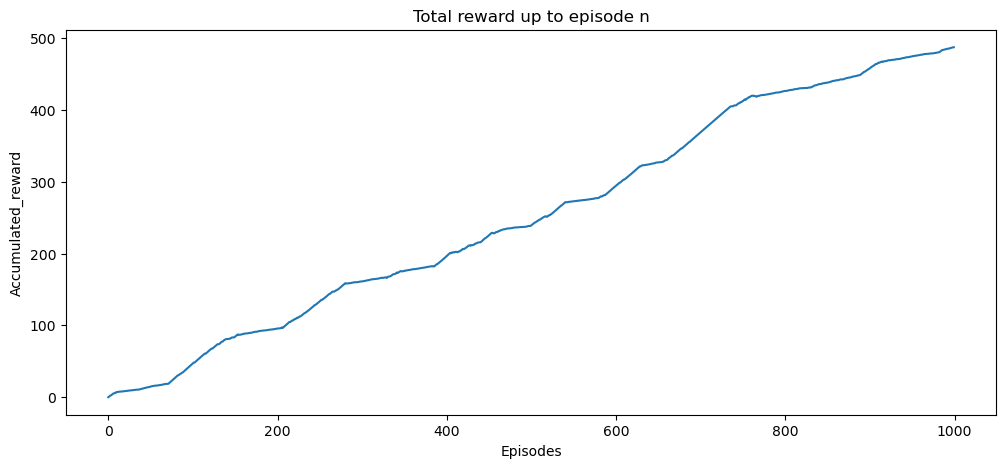

Episode  0 score: 84.00 average score: 84.00 epsilon: 0.00
Episode  100 score: 113.00 average score: 133.89 epsilon: 0.00
Episode  200 score: 88.00 average score: 128.15 epsilon: 0.00
Episode  300 score: 90.00 average score: 129.40 epsilon: 0.00
Episode  400 score: 153.00 average score: 132.76 epsilon: 0.00
Episode  500 score: 148.00 average score: 131.72 epsilon: 0.00
Episode  600 score: 157.00 average score: 130.54 epsilon: 0.00
Episode  700 score: 145.00 average score: 131.37 epsilon: 0.00
Episode  800 score: 90.00 average score: 134.11 epsilon: 0.00
Episode  900 score: 89.00 average score: 121.95 epsilon: 0.00


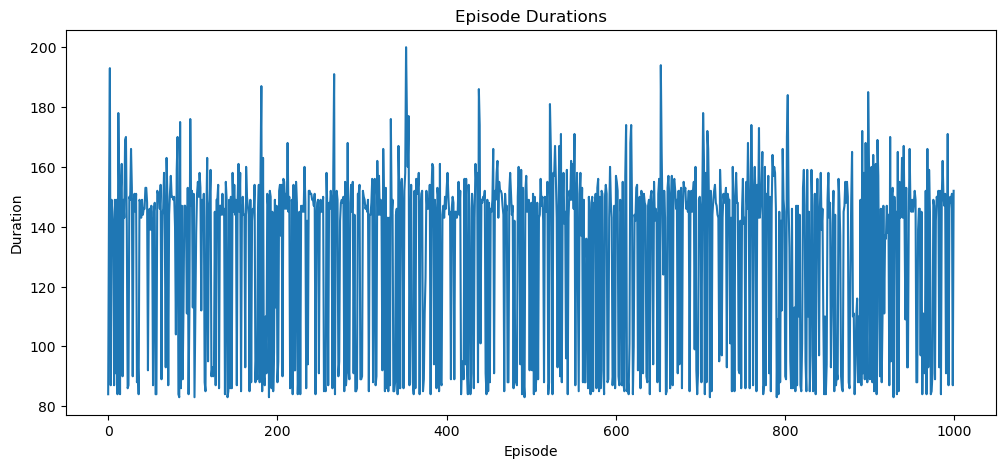

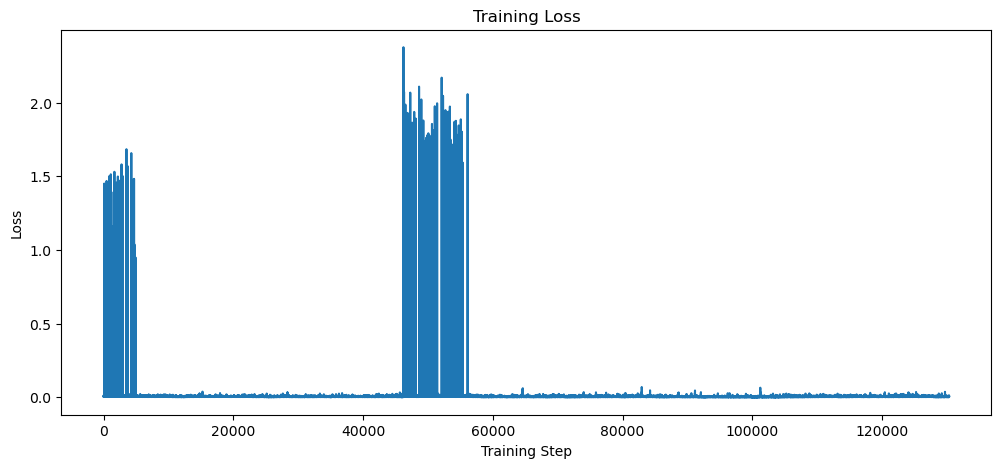

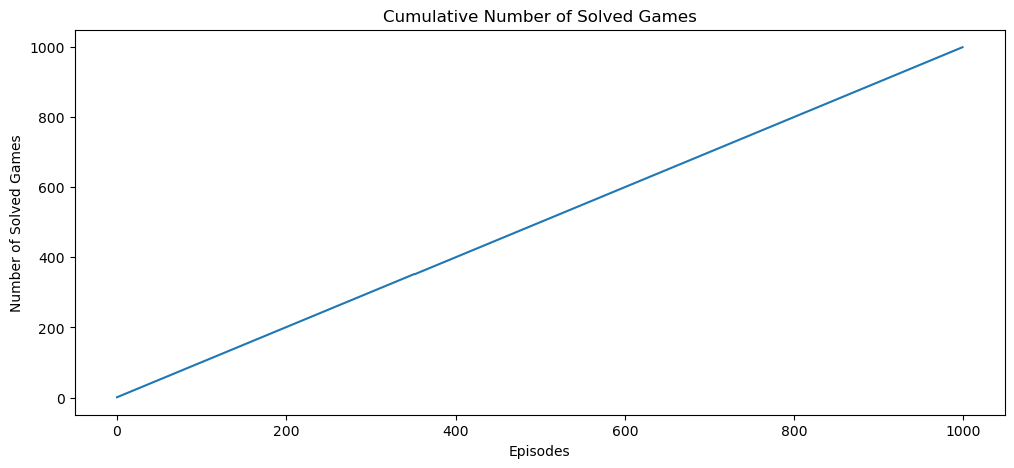

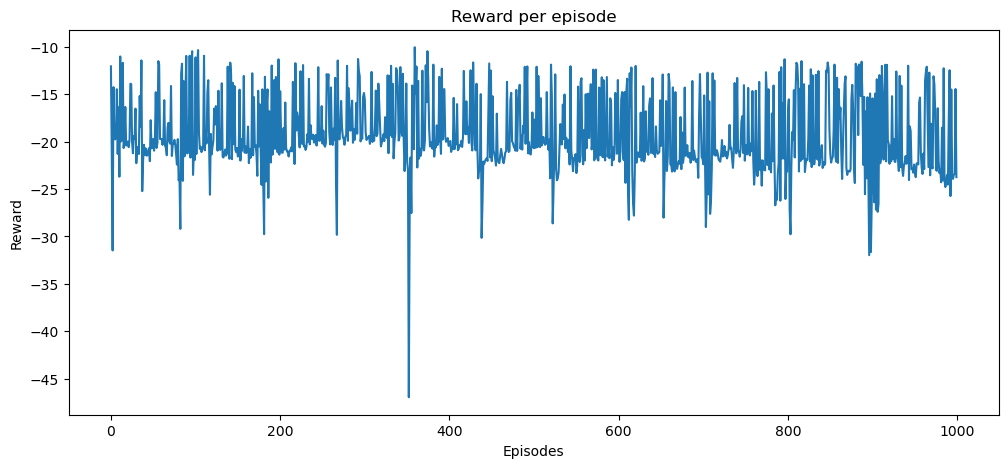

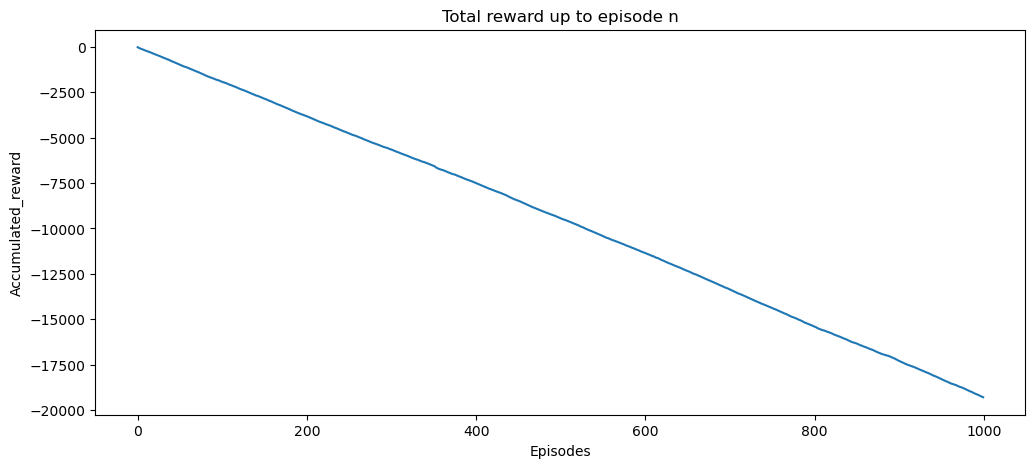

In [21]:
n_games_comp = 1000
randomSeeds = [random.randint(0, 10000) for i in range(n_games_comp)]

dynaAgSave.e[0] = 0
dynaAgSave.e[1] = 0
agent_1.epsilon = 0
agent_1.eps_min = 0
agent_2.epsilon = 0
agent_2.eps_min = 0

###################################################################################################################
#Dyna
###################################################################################################################
scores_dyna_comp, eps_history_dyna_comp, solved_count_history_dyna_comp, accumulated_reward_per_ep_dyna_comp, total_reward_up_to_n_dyna_comp, Qval_dyna_comp = [], [], [], [], [], []
solved_games_dyna_comp = 0  # Counter for the number of games solved
total_reward_up_to_now_dyna_comp = 0

for i in range(n_games_comp):
    steps, total_reward, done = 0, 0, False
    observation, _ = env.reset(seed=randomSeeds[i])
    while not done:
        action = dynaAgSave.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        Qval_dyna_comp.append(dynaAgSave.observe(observation, action, observation_, reward))
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_dyna_comp += reward

    scores_dyna_comp.append(steps)
    accumulated_reward_per_ep_dyna_comp.append(total_reward)
    total_reward_up_to_n_dyna_comp.append(total_reward_up_to_now_dyna_comp)
    if steps < 200:
        solved_games_dyna_comp += 1

    solved_count_history_dyna_comp.append(solved_games_dyna_comp)

    avg_score = np.mean(scores_dyna_comp[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % dynaAgSave.e[0])    

    # Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_dyna_comp)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(Qval_dyna_comp)
plt.title('training Q_value')
plt.xlabel('Training Step')
plt.ylabel('Q_value')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_dyna_comp)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_dyna_comp)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_dyna_comp)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()  
###################################################################################################################
#Heuristique
###################################################################################################################

scores_heu, eps_history_heu, loss_history_heu, solved_count_history_heu, accumulated_reward_per_ep_heu, total_reward_up_to_n_heu, rewards_from_env_heu = [], [], [], [], [], [], []
solved_games_heu = 0  # Counter for the number of games solved
total_reward_up_to_now_heu = 0

for i in range(n_games_comp):
    steps, total_reward, total_env_reward, done = 0, 0, 0, False
    observation, _ = env.reset(seed=randomSeeds[i])
    while not done:
        action = agent_2.choose_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        total_env_reward += reward
        reward = mechanical_energy_reward(observation, observation_)
        steps += 1
        done = terminated or truncated
        agent_2.observe(observation, action, reward, observation_, done)
        loss = agent_2.learn() # When training the agent with heuristic reward, comment out the update of the predictor network for optimization.
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_heu += reward
        loss_history_heu.append(loss)

    scores_heu.append(steps)
    eps_history_heu.append(agent_2.epsilon)
    rewards_from_env_heu.append(total_env_reward)
    accumulated_reward_per_ep_heu.append(total_reward)
    total_reward_up_to_n_heu.append(total_reward_up_to_now_heu)
    if steps < 200:
        solved_games_heu += 1
    solved_count_history_heu.append(solved_games_heu)

    avg_score = np.mean(scores_heu[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % agent_2.epsilon)

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_heu)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_history_heu)
plt.title('Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_heu)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_heu)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_heu)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()

###################################################################################################################
#RND
###################################################################################################################
scores_RND, eps_history_RND, loss_history_RND, solved_count_history_RND, accumulated_reward_per_ep_RND, total_reward_up_to_n_RND, rewards_from_env_RND = [], [], [], [], [], [], []
solved_games_RND = 0  # Counter for the number of games solved
total_reward_up_to_now_RND = 0

for i in range(n_games_comp):
    steps, total_reward, total_env_reward, done = 0, 0, 0, False
    observation, _ = env.reset(seed=randomSeeds[i])
    while not done:
        action = agent_1.choose_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        total_env_reward += reward
        reward = agent_1.compute_rnd_reward(observation_) # change to mechanical_energy reward to train the agent with heuristic reward function
        steps += 1
        done = terminated or truncated
        agent_1.observe(observation, action, reward, observation_, done)
        loss = agent_1.learn() # When training the agent with heuristic reward, comment out the update of the predictor network for optimization.
        observation = observation_
        total_reward += reward
        total_reward_up_to_now_RND += reward
        loss_history_RND.append(loss)

    scores_RND.append(steps)
    eps_history_RND.append(agent_1.epsilon)
    rewards_from_env_RND.append(total_env_reward)
    accumulated_reward_per_ep_RND.append(total_reward)
    total_reward_up_to_n_RND.append(total_reward_up_to_now_RND)
    if steps < 200:
        solved_games_RND += 1
    solved_count_history_RND.append(solved_games_RND)

    avg_score = np.mean(scores_RND[-100:])
    if i % 100 == 0:
      print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % agent_1.epsilon)

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores_RND)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_history_RND)
plt.title('Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history_RND)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep_RND)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n_RND)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()


In [20]:
with open('Models.pkl', 'rb') as intp:
    agent_1 = pickle.load(intp)
    agent_2 = pickle.load(intp)
    scores_1 = pickle.load(intp)
    scores_2 = pickle.load(intp)
    eps_history_1 = pickle.load(intp)
    eps_history_2 = pickle.load(intp)
    loss_history_1 = pickle.load(intp)
    loss_history_2 = pickle.load(intp)
    solved_count_history_1 = pickle.load(intp)
    solved_count_history_2 = pickle.load(intp)
    accumulated_reward_per_ep_1 = pickle.load(intp)
    accumulated_reward_per_ep_2 = pickle.load(intp)
    total_reward_up_to_n_1 = pickle.load(intp)
    total_reward_up_to_n_2 = pickle.load(intp)
    rewards_from_env_1 = pickle.load(intp)
    rewards_from_env_2 = pickle.load(intp)
    total_reward_up_to_now_1 = pickle.load(intp)
    total_reward_up_to_now_2 = pickle.load(intp)
    
with open('DynaModel.pkl', 'rb') as intp:
    dynaAgSave = pickle.load(intp)
    scores_3 = pickle.load(intp)
    eps_history_3 = pickle.load(intp)
    
with open('DynaModelFollow.pkl', 'rb') as intp:
    Qval = pickle.load(intp)
    solved_count_history_3 = pickle.load(intp)
    accumulated_reward_per_ep_3 = pickle.load(intp)
    total_reward_up_to_n_3 = pickle.load(intp)
    total_reward_up_to_now_3 = pickle.load(intp)

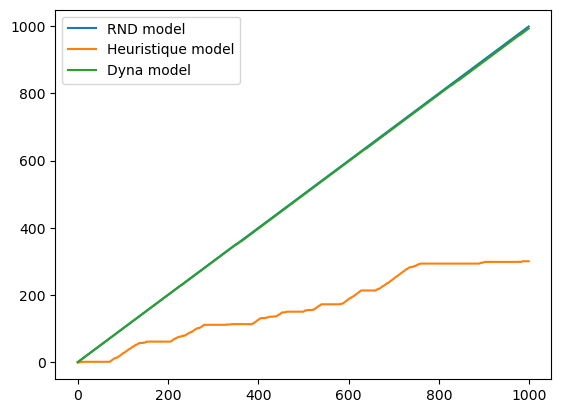

In [32]:
plt.plot(solved_count_history_RND, label = "RND model")
plt.plot(solved_count_history_heu, label = "Heuristique model")
plt.plot(solved_count_history_dyna_comp, label = "Dyna model")
plt.legend()
plt.show()